# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

class custom_iter: # custom iterator class that allows for retrieval of current element w/out advancing
    def __init__(self, iterable):
        self.iterator = iter(iterable)
        self.current = None
    def __next__(self):
        try:
            self.current = next(self.iterator)
        except StopIteration:
            self.current = None
        finally:
            return self.current

In [2]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2] # filter catalog for GRBs with T90 under 2 sec

## Data parsing and cleanup

In [3]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([]) # numerical magnitudes
lims = pd.Series([]) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [4]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [5]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs

error 186; error 314; error 493; error 534; error 582; error 611; error 693; error 826; error 1021; error 1036; error 1102; error 1255;

In [6]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [7]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
26,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 26}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
35,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest
73,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest
103,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 103}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
107,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 107},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.3,brightest


## Old data handling

In [8]:
BetaXData = pd.read_csv("./Required Files/Files for Loading/BetaXData.csv", header=None)
OpticalData = pd.read_csv("./Required Files/Files for Loading/OpticalData.csv", header=None)
XRayData = pd.read_csv("./Required Files/Files for Loading/XRayData.csv", header=None)

In [9]:
old_ids = np.unique([entry.split("-")[1] for entry in XRayData.iloc[:,0]]+
                    [entry.split("-")[1] for entry in OpticalData.iloc[:,0]]+
                    [entry.split("-")[1] for entry in BetaXData.iloc[:,0]])

print(old_ids) # all the GRB IDs that David already looked at in his work

#new_sGRBs = sGRBs[~sGRBs["GRB"].isin(old_ids)] # filter such that we're only working with GRBs that David ~didn't~ already look at
new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]] # Fong et al. 2015 has data through March 2015, i.e. 150301A

['050202' '050509B' '050709' '050724A' '050813' '050906' '050925' '051210'
 '051221A' '060121' '060313' '060502B' '060801' '061006' '061201' '061210'
 '061217' '070209' '070406' '070429B' '070707' '070714B' '070724A'
 '070729' '070809' '070810B' '071017' '071112B' '071227' '080121' '080123'
 '080426' '080503' '080702A' '080905A' '080919' '081024A' '081024B'
 '081226A' '081226B' '090305' '090305A' '090426' '090426A' '090510'
 '090515' '090607' '090621B' '090916' '091109B' '091117' '100117A'
 '100206A' '100213' '100625A' '100628A' '100702A' '101219A' '101224A'
 '110112A' '110112B' '110420B' '111020A' '111117A' '111121A' '111222A'
 '120229A' '120305A' '120521A' '120630A' '120804A' '120817B' '121226A'
 '130313A' '130515A' '130603B' '130626A' '130716A' '130822A' '130912A'
 '131004A' '131125A' '131126A' '131224A' '140129B' '140320A' '140402A'
 '140414A' '140516A' '140606A' '140619B' '140622A' '140903A' '140930B'
 '141202A' '141205A' '141212A' '150101A' '150101B' '150120A' '150301A']


In [10]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
26,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 26}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
35,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
73,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
103,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 103}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
107,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 107},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
115,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 115}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
121,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 121}",Insight-HXMT/HE,NaN,NaN,equal
150,181123B,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest
179,180805A,851829,1.68,86.13,-0.3151,1.50420,89,V>18.0,"{'B': '19.1', 'U': '19.6', 'UVM2': '19.4', 'UV...",NaN,NaN,18.00,brightest
181,180727A,850231,1.1,NaN,-2.353,1.85342,77,V>19.6,"{'B': '21.2', 'U': '20.3', 'UVM2': '21.0', 'UV...",Fermi (GBM),NaN,19.60,brightest


In [24]:
burst = "200411A"
trigger = new_sGRBs.loc[sGRBs["GRB"] == burst, "TriggerNumber"]
lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/flux.qdp"
spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"

In [25]:
fluxdata = pd.read_table(lightcurveURL, header=11).apply(pd.to_numeric, errors="coerce").dropna().reset_index(drop=True)
fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]

spectra_tables = pd.read_html(spectrumURL)
PC_table = spectra_tables[len(spectra_tables)-2]
photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
(Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())

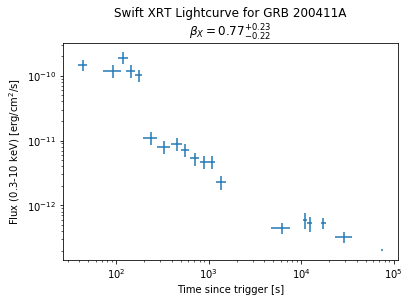

In [26]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/cm$^2$/s]")
plt.show()

In [14]:
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    trigger = new_sGRBs.loc[i,"TriggerNumber"]
    
    try:
        lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/flux.qdp"
        spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"
    
        spectra_tables = pd.read_html(spectrumURL)
        PC_table = spectra_tables[len(spectra_tables)-2]
        photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
        (Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())
        
        new_sGRBs.loc[i,"Beta_X"] = 1. - Gamma
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammapos
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammaneg
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve data for GRB",GRB_ID)

Failed to retrieve data for GRB 190610A
Failed to retrieve data for GRB 190427A
Failed to retrieve data for GRB 190326A
Failed to retrieve data for GRB 180718A
Failed to retrieve data for GRB 180715A
Failed to retrieve data for GRB 170325A
Failed to retrieve data for GRB 170112A
Failed to retrieve data for GRB 160726A
Failed to retrieve data for GRB 160714A
Failed to retrieve data for GRB 151228A
Failed to retrieve data for GRB 151205B
Failed to retrieve data for GRB 150710A


In [15]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim,Beta_X,Beta_X_neg,Beta_X_pos
26,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 26}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest,-0.38,0.43,0.29
35,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest,-0.77,0.23,0.22
73,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest,-0.80,4.60,0.90
103,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 103}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal,-1.00,0.14,0.12
107,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 107},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest,NaN,NaN,NaN
115,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 115}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal,NaN,NaN,NaN
121,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 121}",Insight-HXMT/HE,NaN,NaN,equal,NaN,NaN,NaN
150,181123B,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest,-1.04,0.30,0.24
179,180805A,851829,1.68,86.13,-0.3151,1.50420,89,V>18.0,"{'B': '19.1', 'U': '19.6', 'UVM2': '19.4', 'UV...",NaN,NaN,18.00,brightest,-0.51,0.56,0.25
181,180727A,850231,1.1,NaN,-2.353,1.85342,77,V>19.6,"{'B': '21.2', 'U': '20.3', 'UVM2': '21.0', 'UV...",Fermi (GBM),NaN,19.60,brightest,-0.80,0.40,0.40
